In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

from IPython.display import clear_output
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

from os import listdir
from os.path import isfile, join
import os
#os.getcwd()
#os.chdir('/Users/Grant/Documents/Model Risk Mgmt/Project')
import warnings
warnings.filterwarnings('ignore')


In [8]:
os.getcwd()
#os.chdir('/Users/Grant/Documents/Model Risk Mgmt/MRM-Project')

'/Users/Grant/Documents/Model Risk Mgmt/MRM-Project'

**Your code below**

*   Reduce the overall data set to 200K rows or less
*   Split your data for training / testing
*   Build at least two models with `loan_status` as the target
*   Report on the model's performance
*   Report on the model's drivers (feature importance / effects)

Plant 2 flaws in this notebook.  Do not "give away" the answers here.  This notebook should appear, at first glance, to create a viable model.

Make a note of your flaws and be prepared to talk about how the code / results look when they are "fixed".  You will need to talk about those in the final presentation.

In [9]:
loan_df = pd.read_pickle('clean_df_for_eda.pkl')

In [10]:
loan_df.fully_paid.value_counts(normalize = True)

1    0.796288
0    0.203712
Name: fully_paid, dtype: float64

In [11]:
subset_size = 200000

# Calculate the sample size for each category in the target column
proportions = loan_df['fully_paid'].value_counts(normalize=True)
sample_sizes = (proportions * subset_size).round().astype(int)

# Perform stratified sampling on the target column
loan_df = (
    loan_df.groupby('fully_paid', group_keys=False)
    .apply(lambda group: group.sample(n=sample_sizes[group.name], random_state=42))
)

loan_df.fully_paid.value_counts(normalize = True)

1    0.79629
0    0.20371
Name: fully_paid, dtype: float64

In [12]:
num_cols = loan_df.select_dtypes(include=['float64'])

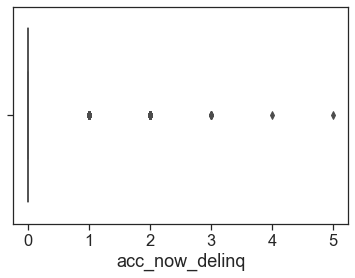

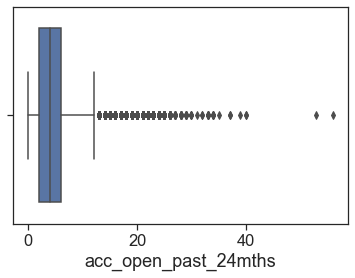

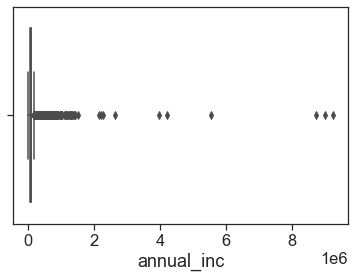

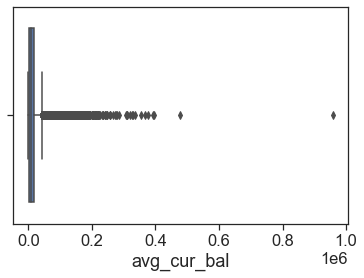

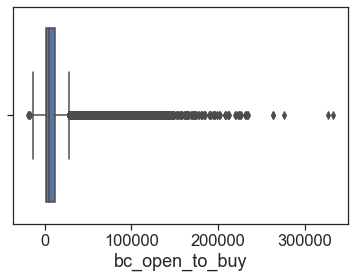

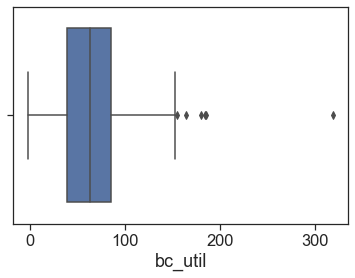

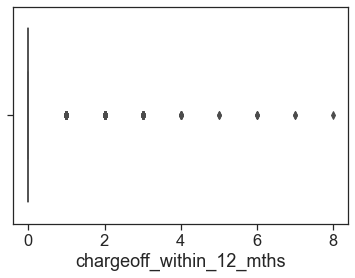

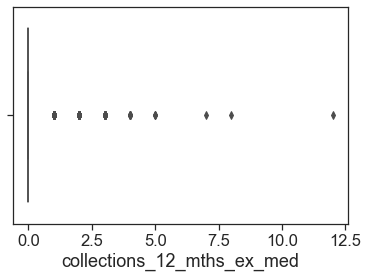

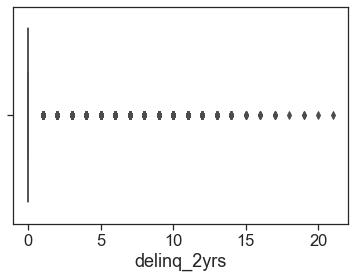

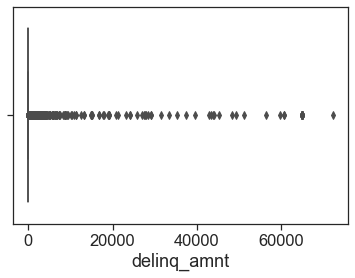

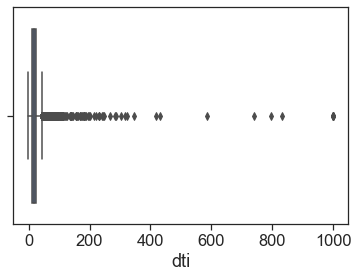

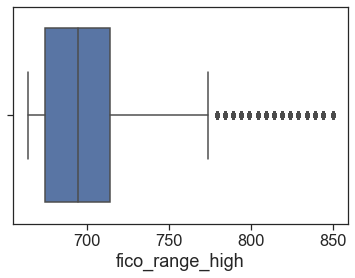

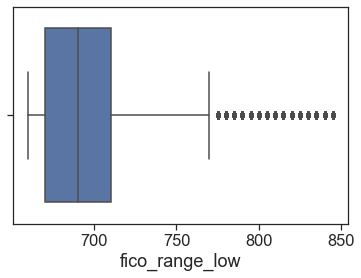

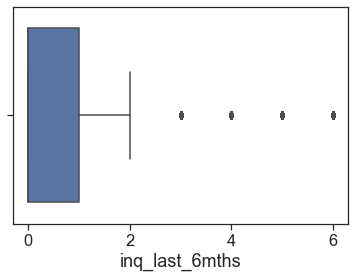

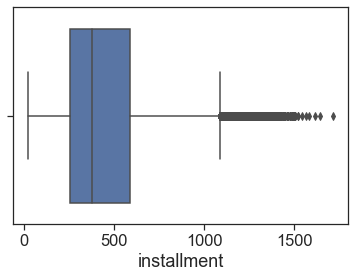

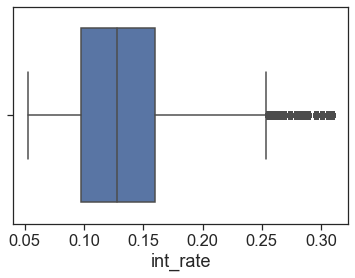

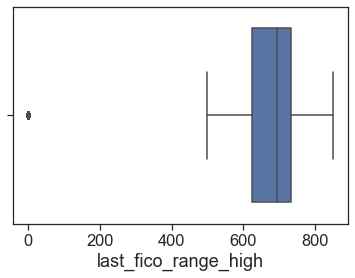

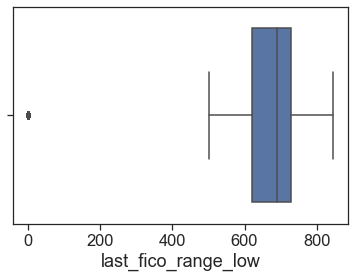

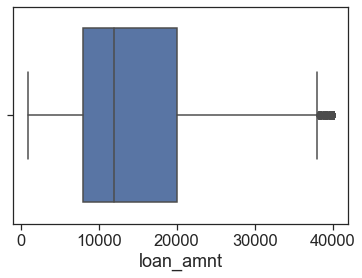

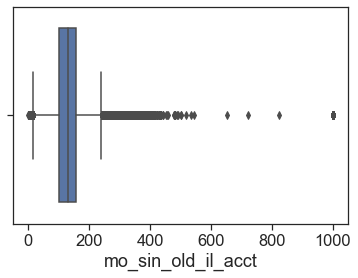

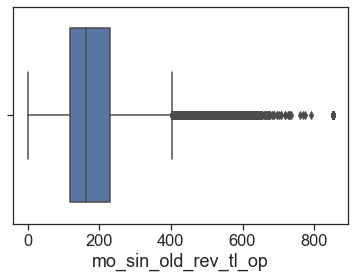

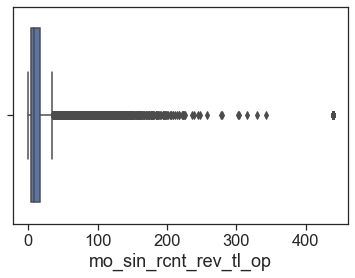

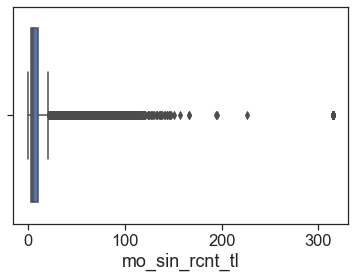

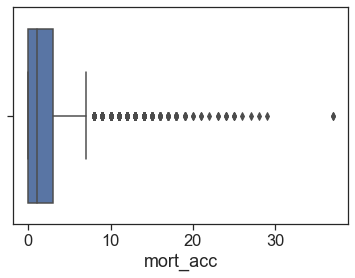

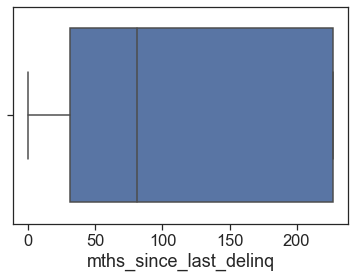

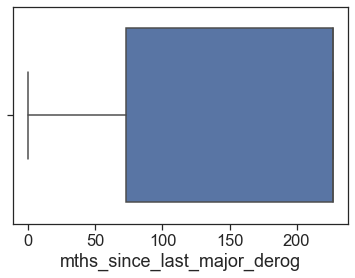

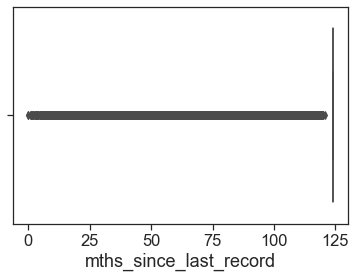

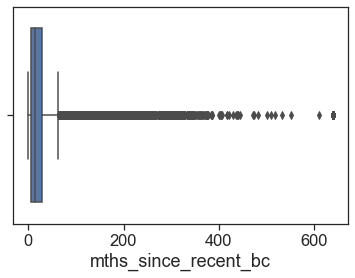

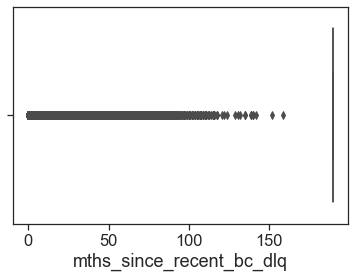

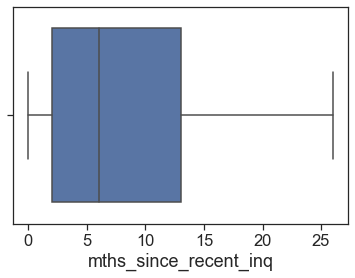

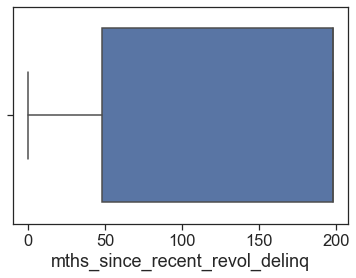

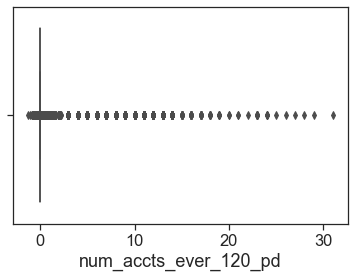

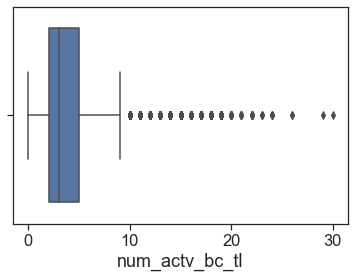

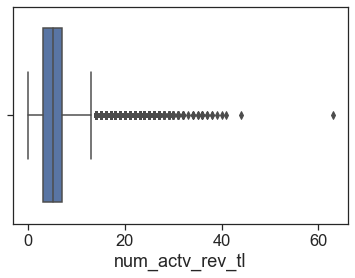

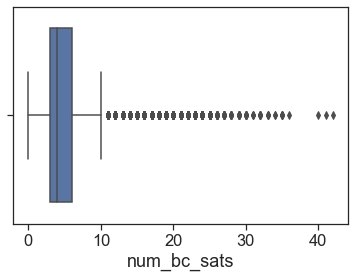

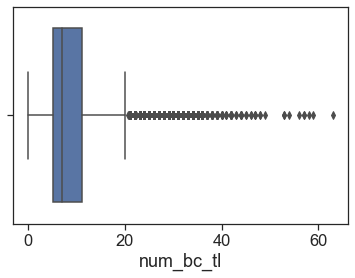

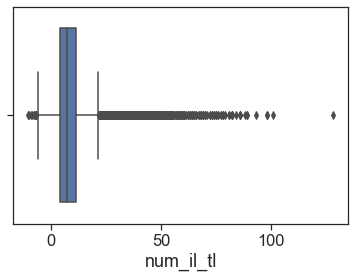

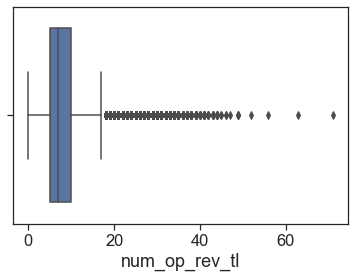

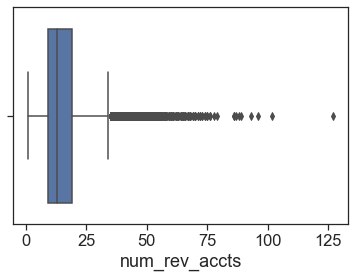

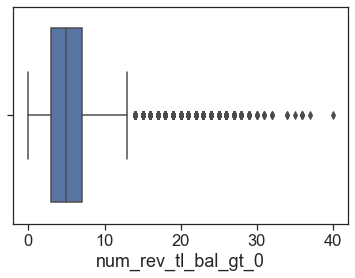

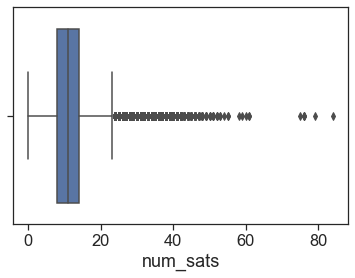

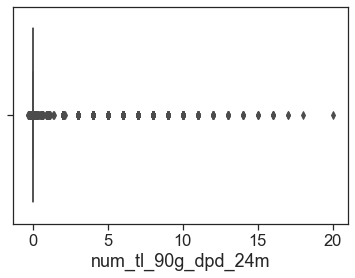

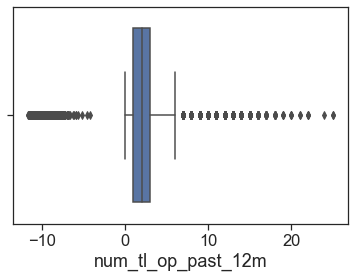

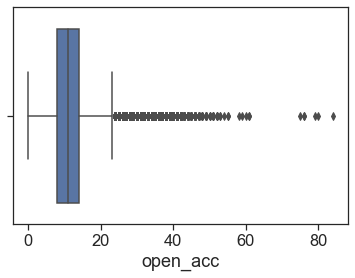

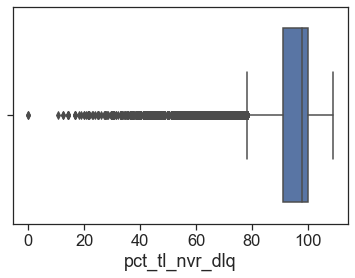

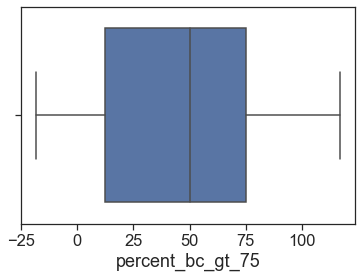

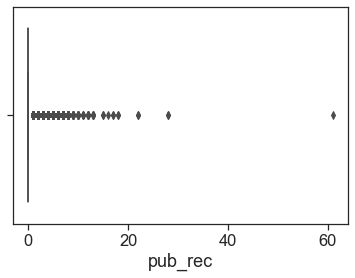

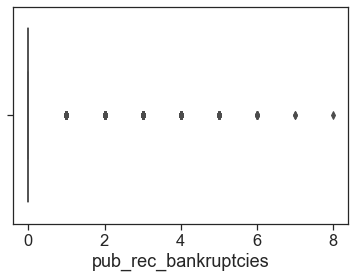

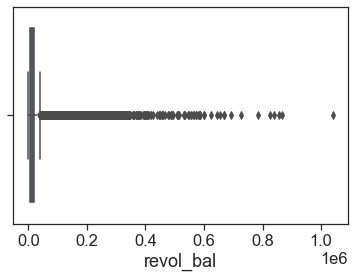

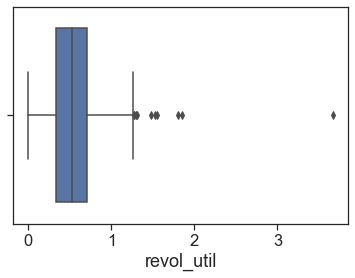

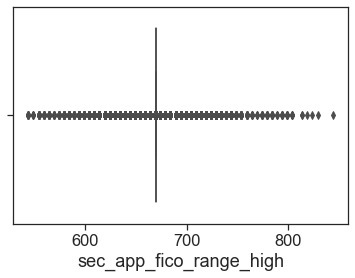

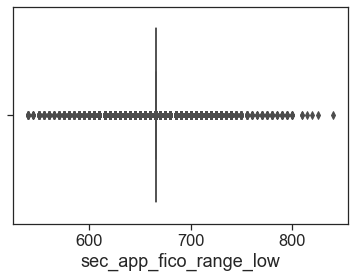

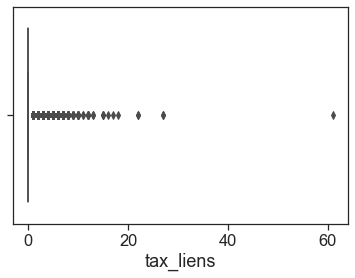

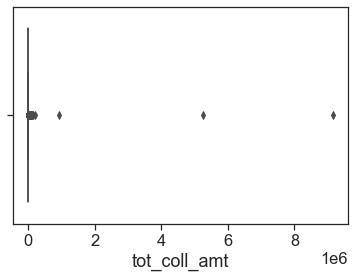

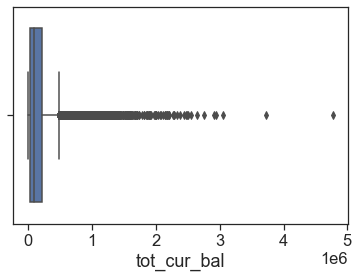

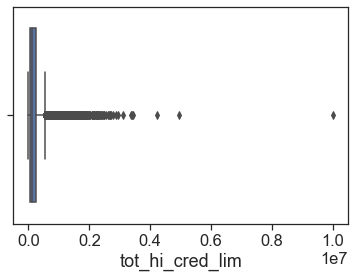

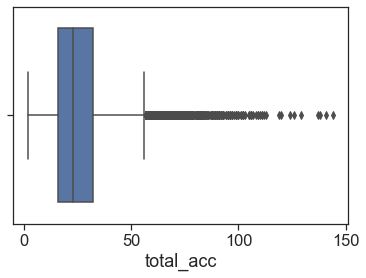

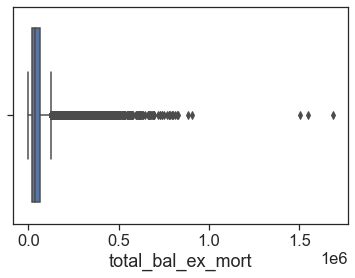

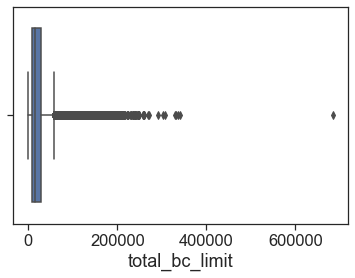

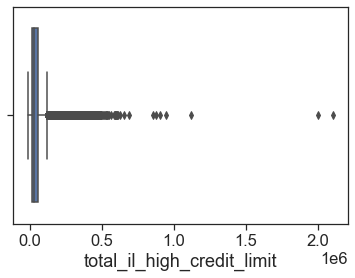

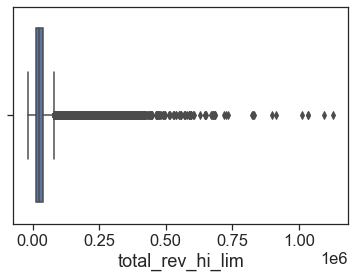

In [13]:
for col in num_cols:
    sns.boxplot(data = loan_df, x = col)
    plt.show()

In [38]:
from scipy.stats import zscore
# Calculate Z-scores
z_scores = num_cols.apply(zscore)

# Filter out rows with any Z-scores > 3 or < -3
num_cols_no_outliers = num_cols[(z_scores < 3).all(axis=1)]
df_no_outliers = pd.concat([num_cols_no_outliers, loan_df.drop(columns=num_cols.columns)], axis=1)
df_no_outliers.dropna(inplace = True)

In [39]:
loan_df.shape

(200000, 99)

In [40]:
df_no_outliers.shape

(140910, 99)

In [41]:
df_no_outliers['year']=df_no_outliers['issue_d'].dt.year
df_no_outliers['month']=df_no_outliers['issue_d'].dt.month

In [42]:
df_no_outliers['addr_state']=df_no_outliers['addr_state'].astype('category')
df_no_outliers['application_type']=df_no_outliers['application_type'].astype('category')
df_no_outliers['emp_length']=df_no_outliers['emp_length'].astype('category')
df_no_outliers['home_ownership']=df_no_outliers['home_ownership'].astype('category')
df_no_outliers['purpose']=df_no_outliers['purpose'].astype('category')
df_no_outliers['verification_status']=df_no_outliers['verification_status'].astype('category')
df_no_outliers['term']=df_no_outliers['term'].astype('category')

In [43]:
df_no_outliers.dtypes

acc_now_delinq           float64
acc_open_past_24mths     float64
annual_inc               float64
avg_cur_bal              float64
bc_open_to_buy           float64
                          ...   
purpose                 category
term                    category
verification_status     category
year                       int64
month                      int64
Length: 101, dtype: object

In [44]:
sorted(df_no_outliers.columns)

['acc_now_delinq',
 'acc_open_past_24mths',
 'addr_state',
 'annual_inc',
 'application_type',
 'application_type_Joint App',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'credit_line_age',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'emp_length_10+ years',
 'emp_length_2-4 years',
 'emp_length_5-9 years',
 'fico_range_high',
 'fico_range_low',
 'fully_paid',
 'grade',
 'home_ownership',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'month',
 'mort_acc',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mth

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pandas as pd


In [15]:
# Save model dataframe to a pickle file for easier reading
#model_df.to_pickle('model_df.pkl')
model_df = pd.read_pickle('model_df.pkl')

In [16]:
#model_df = df_no_outliers.copy()
X = model_df.drop(columns = ['grade','sub_grade','fully_paid','installment','int_rate','zip_code','issue_d'])
y = model_df['fully_paid']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.25, random_state=42)

## Optuna study for hyper-paramter tuning

In [18]:
import optuna
import lightgbm as lgb
import sklearn.metrics

from sklearn.model_selection import train_test_split

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):
    data, target = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, stratify=target)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(valid_y, pred_labels)
    recall = sklearn.metrics.recall_score(valid_y, pred_labels)
    return accuracy, recall

In [14]:
y.value_counts()

1    112445
0     28465
Name: fully_paid, dtype: int64

In [19]:
study = optuna.create_study(directions=['maximize','maximize'])
study.optimize(objective, n_trials=100)

[I 2024-11-17 16:31:49,427] A new study created in memory with name: no-name-aa1d304b-c687-4f4a-ae6d-dba0a12f2c2a
[I 2024-11-17 16:31:52,361] Trial 0 finished with values: [0.9133075962302714, 0.9504482071713147] and parameters: {'lambda_l1': 2.2709299646541092e-05, 'lambda_l2': 2.3778595950056878, 'num_leaves': 159, 'feature_fraction': 0.8539826658136442, 'bagging_fraction': 0.6169771344775887, 'bagging_freq': 3, 'min_child_samples': 14}.
[I 2024-11-17 16:31:53,136] Trial 1 finished with values: [0.9131656636766209, 0.9426223676721684] and parameters: {'lambda_l1': 1.741569268815296e-07, 'lambda_l2': 0.04975677144705603, 'num_leaves': 4, 'feature_fraction': 0.6420459724724633, 'bagging_fraction': 0.5658430773077071, 'bagging_freq': 5, 'min_child_samples': 9}.
[I 2024-11-17 16:31:55,023] Trial 2 finished with values: [0.9138185534234132, 0.9483494593056346] and parameters: {'lambda_l1': 0.0004454812989246676, 'lambda_l2': 0.0003127034175070696, 'num_leaves': 82, 'feature_fraction': 0.8

In [20]:
study.best_trials

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9133075962302714, 0.9504482071713147], datetime_start=datetime.datetime(2024, 11, 17, 16, 31, 49, 429231), datetime_complete=datetime.datetime(2024, 11, 17, 16, 31, 52, 360866), params={'lambda_l1': 2.2709299646541092e-05, 'lambda_l2': 2.3778595950056878, 'num_leaves': 159, 'feature_fraction': 0.8539826658136442, 'bagging_fraction': 0.6169771344775887, 'bagging_freq': 3, 'min_child_samples': 14}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'lambda_l1': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'lambda_l2': FloatDistribution(high=10.0, log=True, low=1e-08, step=None), 'num_leaves': IntDistribution(high=256, log=False, low=2, step=1), 'feature_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_fraction': FloatDistribution(high=1.0, log=False, low=0.4, step=None), 'bagging_freq': IntDistribution(high=7, log=False, low=1, step=1), 'min

In [52]:
trial = optuna.trial.Trial(study,45)

In [53]:
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  Params: 
    lambda_l1: 6.498748835449569
    lambda_l2: 4.307245675642885e-08
    num_leaves: 158
    feature_fraction: 0.8916935467896057
    bagging_fraction: 0.7861018258900571
    bagging_freq: 7
    min_child_samples: 9


In [54]:
params = trial.params
params

{'lambda_l1': 6.498748835449569,
 'lambda_l2': 4.307245675642885e-08,
 'num_leaves': 158,
 'feature_fraction': 0.8916935467896057,
 'bagging_fraction': 0.7861018258900571,
 'bagging_freq': 7,
 'min_child_samples': 9}

[LightGBM] [Warning] lambda_l1 is set=1.4093746514830682e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4093746514830682e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.6600077162526377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6600077162526377
[LightGBM] [Warning] lambda_l2 is set=5.258998185678545e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.258998185678545e-07
[LightGBM] [Warning] bagging_fraction is set=0.9802010400709571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9802010400709571
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1.4093746514830682e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4093746514830682e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current val

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

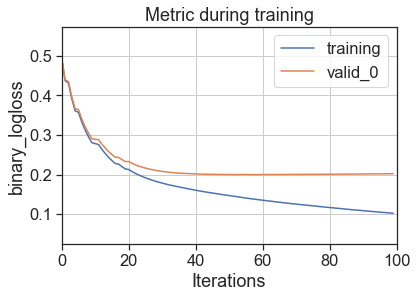

In [19]:
lgbm = lgb.LGBMClassifier(lambda_l1= 1.4093746514830682e-07,
    lambda_l2= 5.258998185678545e-07,
    num_leaves= 204,
    feature_fraction= 0.6600077162526377,
    bagging_fraction= 0.9802010400709571,
    bagging_freq= 5,
    min_child_samples= 89)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))
lgb.plot_metric(lgbm)

In [23]:
lgbm = lgb.LGBMClassifier(lambda_l1= 0.013291314585684007,
    lambda_l2= 0.0021574229713529607,
    num_leaves= 22,
    feature_fraction= 0.9291348308588118,
    bagging_fraction= 0.7043465256980788,
    bagging_freq= 3,
    min_child_samples= 99
)
lgbm.fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])


[LightGBM] [Warning] lambda_l1 is set=0.013291314585684007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013291314585684007
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9291348308588118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9291348308588118
[LightGBM] [Warning] lambda_l2 is set=0.0021574229713529607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021574229713529607
[LightGBM] [Warning] bagging_fraction is set=0.7043465256980788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7043465256980788
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.013291314585684007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013291314585684007
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagg

LGBMClassifier(bagging_fraction=0.7043465256980788, bagging_freq=3,
               feature_fraction=0.9291348308588118,
               lambda_l1=0.013291314585684007, lambda_l2=0.0021574229713529607,
               min_child_samples=99, num_leaves=22)

In [24]:
print('Training accuracy {:.4f}'.format(lgbm.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(lgbm.score(X_test,y_test)))

[LightGBM] [Warning] lambda_l1 is set=0.013291314585684007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013291314585684007
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.9291348308588118, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9291348308588118
[LightGBM] [Warning] bagging_fraction is set=0.7043465256980788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7043465256980788
[LightGBM] [Warning] lambda_l2 is set=0.0021574229713529607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021574229713529607
Training accuracy 0.9236
[LightGBM] [Warning] lambda_l1 is set=0.013291314585684007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013291314585684007
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

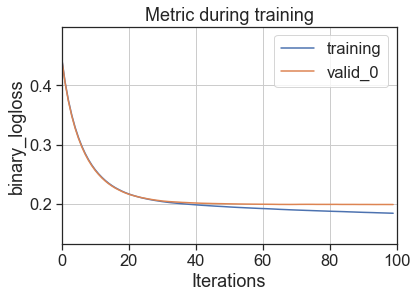

In [25]:
lgb.plot_metric(lgbm)

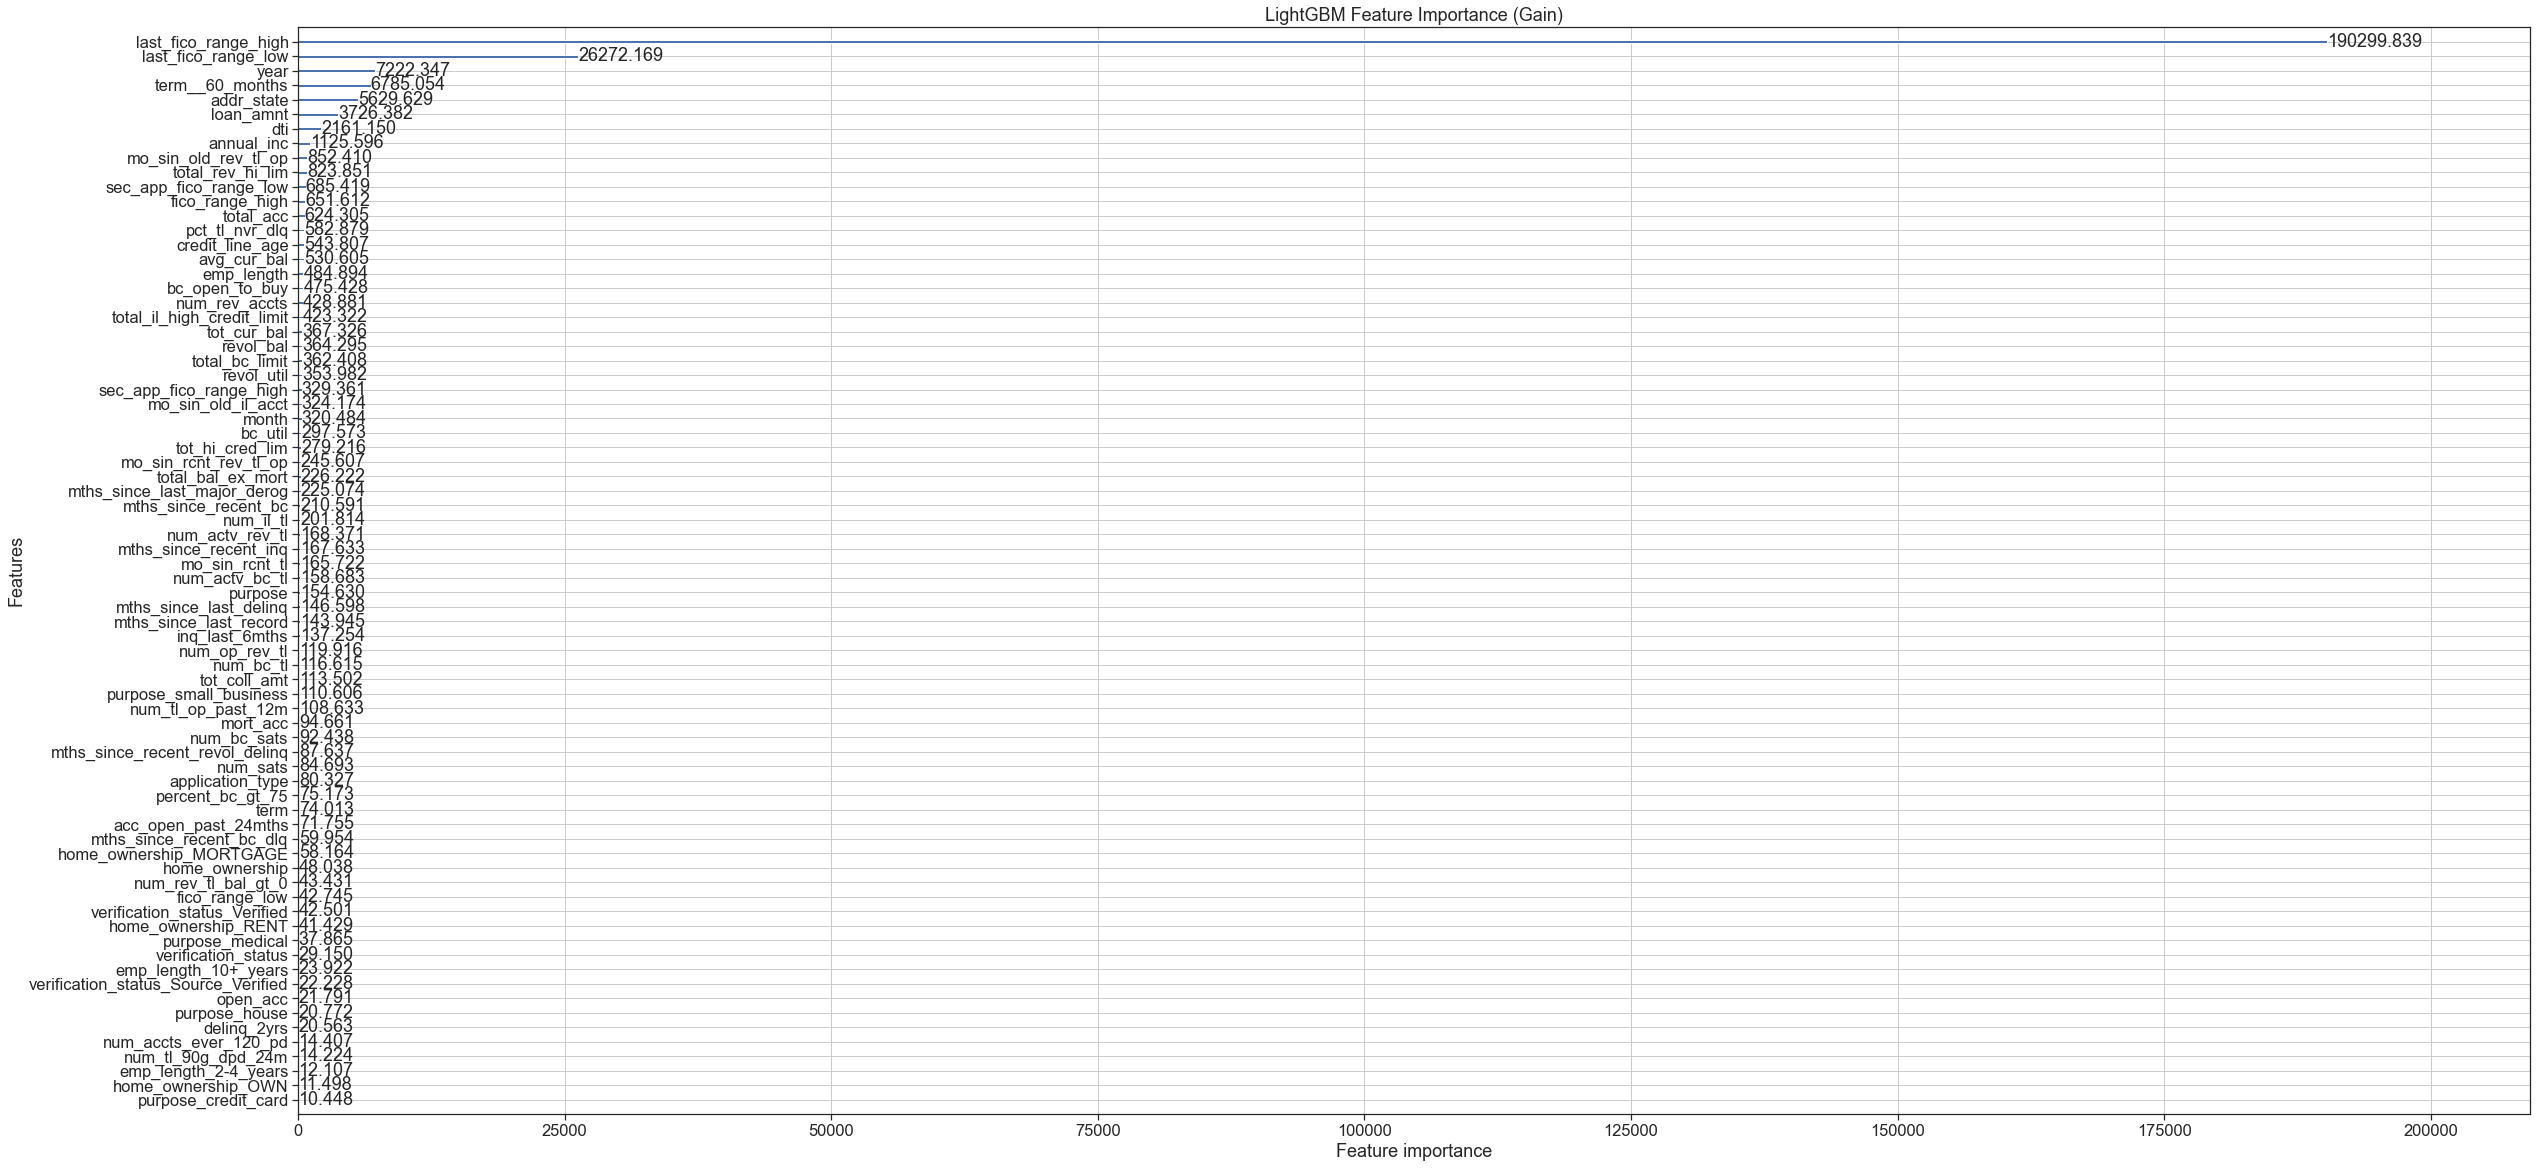

In [26]:
lgb.plot_importance(lgbm, importance_type="gain", figsize=(40,20), title="LightGBM Feature Importance (Gain)")
plt.show()

# Fico-range high is wildly more important than the other features, but it makes sense. Inidivudals with high scores are more likely to pay off loans. Consider dropping it for future models?